# 0. Notes:

This notebook identifies vessels transiting Bosporus Strait during Russian-Invasion of Ukraine.

Connect to the UN Global Platform and use kernel `pyspark3.5 ais2.9`

# 1. Initialize

In [1]:
import geopandas as gpd
from shapely.geometry import mapping, Polygon

from pyspark.sql import functions as F
from pyspark.sql import Window as W
from ais import functions as af
import h3.api.numpy_int as h3int

import matplotlib.pyplot as plt

generated new fontManager


In [2]:
from sedona.spark import *

sedona = SedonaContext.create(spark)

Skipping SedonaKepler import, verify if keplergl is installed
Skipping SedonaPyDeck import, verify if pydeck is installed


In [3]:
import requests
import base64
import os
import pandas as pd
from io import StringIO

In [4]:
passageway = "bosporus_strait"
raw_ais_save_path = os.environ["USER_TEMP_S3PATH"] + f"cherryl/ais_passageways/{passageway}/ais/"

# 2. Geometries

In [5]:
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/{passageway}.geojson")
gdf = gpd.read_file(base64.b64decode(request.json()['content']).decode('utf-8'))
gdf

,POI,Label,geometry
0,South,South Anchorage 1,"POLYGON ((29.16083 40.87750, 29.17167 40.85000..."
1,North,North Anchorage,"POLYGON ((29.16457 41.34072, 29.03290 41.32238..."
2,South,South Anchorage 2,"POLYGON ((28.99807 41.02488, 28.99507 41.02788..."
3,Middle,Narrowest Area,"POLYGON ((29.06307 41.10538, 29.06622 41.10490..."


Input polygon is too small to be filled in with hexagon of resolution: 6
Attempting to fit a hex of resolution: 7...
A hex of resolution: 7 fits the input polygon
Finding it's parent in resolution: 6
Input polygon is too small to be filled in with hexagon of resolution: 6
Attempting to fit a hex of resolution: 7...
Attempting to fit a hex of resolution: 8...
A hex of resolution: 8 fits the input polygon
Finding it's parent in resolution: 6

H3 count:53


<Axes: >

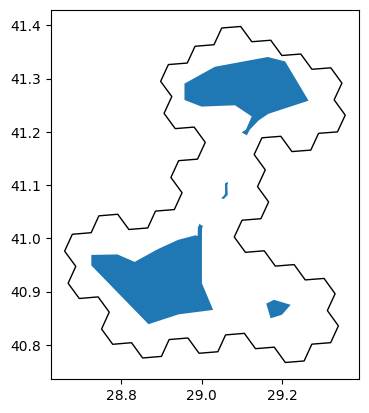

In [9]:
#We use H3 indices (https://h3geo.org/docs) as a geo-spatial filter for AIS data in the UNGP. 
#To get all AIS data within the AOIs, we overfill the geometries with H3 indices, then use the list of H3 indices as filter.  
#To ensure that the filtering is efficient, the number of H3 indices should small and the area outside of the AOI should also be small
#here, we chose H3 index resolution 6. 

h3_resolution = 6

inputs = [(row['Label'], mapping(row['geometry'])) for index, row in gdf.iterrows()]
hex_df = af.polygon_to_hex_df(inputs, h3_resolution, overfill=True)
hexes = hex_df['hex_id'].drop_duplicates().tolist()

print(f"\nH3 count:{len(hexes)}")
hexes = hex_df['hex_id'].drop_duplicates().tolist()
h3_gdf = gpd.GeoDataFrame([["H3",Polygon(h3int.h3_set_to_multi_polygon(hexes, geo_json=True)[0][0])]], columns=['h3','geometry'], crs=4326)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
h3_gdf.plot(ax=ax, facecolor="none")

# 3. Extract AIS data and save to S3

## 3.1 Preparation

In [10]:
ais_cols = [
 'mmsi',
 'longitude',
 'latitude',
 'imo',
 'vessel_name',
 'vessel_type',
 'destination',
 'sog',
 'nav_status',
 'dt_pos_utc']

In [11]:
#Read Ship Register datasets as a spark dataframe, use version 20220502 which is version covering the disruption
#note that af module is from the ais package 

#The ShipData table provides information on the vessel's IMO, vessel type described by the StatCode5 and ShiptypeLevel5
ihs = af.read_ihs_table(spark, "ShipData.CSV", version="20220502") \
.select("ShipName","LRIMOShipNo","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5")

#We use the tblShipTypeCodes table to get more information on the vessel type.
#We select only "Cargo-carrying vessels" which is identified by ShiptypeLevel2 information
ihs_statcode = af.read_ihs_table(spark, "tblShipTypeCodes.CSV",  version="20210609") \
.select("StatCode5","ShiptypeLevel2") \
.filter(F.col("ShiptypeLevel2").isin(["Bulk Carriers", "Dry Cargo/Passenger", "Tankers"]))

In [12]:
#Convert geometries to spark dataframe to prepare for spark processing of geospatial data
sdf_poly = sedona.createDataFrame(gdf[['geometry','POI']])

In [13]:
def extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="overwrite"):
    #Read AIS within the start date and end date where hex ids are within the hexes list
    sdf = af.get_ais(spark, start_date=start_date, end_date=end_date, h3_list = hexes)
    
    #Get only AIS where location is within the POI geometries
    sdf_w_point = sdf.withColumn("point", F.expr("ST_Point(longitude, latitude)"))
    sdf_w_point.createOrReplaceTempView("ais_temp")
    sdf_poly.createOrReplaceTempView("poly_temp")
    sdf_poly_filter = spark.sql(""" select  * from ais_temp, poly_temp where ST_Within(point, geometry)""")
    
    #Get only AIS where the type is cargo related
    sdf_cargo = sdf_poly_filter.join(ihs.withColumnRenamed("LRIMOShipNo","imo"), how="inner", on=['imo']) \
    .join(ihs_statcode, how="inner", on=['StatCode5']) \
    .select(*ais_cols, "ShipName","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5","ShiptypeLevel2","POI") \
    .withColumns({"year":F.year("dt_pos_utc"),"month":F.month("dt_pos_utc")})
    
    #Save in S3
    sdf_cargo.write.mode(mode).partitionBy("year","month").parquet(raw_ais_save_path)
    return sdf_cargo

## 3.2 Run

In [17]:
#Run the extraction process per month.Overwrite for the first time,and then append the next one
start_date = "2022-01-01"
end_date = "2022-01-31"
sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="overwrite")

In [18]:
start_date = "2022-02-01"
end_date = "2022-02-28"
sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [19]:
start_date = "2022-03-01"
end_date = "2022-03-31"
sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

# 4. Get transits

## 4.1 Preparation

In [7]:
w = W.partitionBy("imo").orderBy("dt_pos_utc")
def get_transits(sdf, min_time_diff):
    #This function identifies the "voyages" of a vessel
    #The voyage groups together consecutive messages that likely came from a single transit through the passageway
    #A message is identified to have come from a different voyage is the time between the messages is at least a defined time period
    sdf_groups = sdf.withColumn("prev_dt_pos_utc", F.lag("dt_pos_utc").over(w)) \
    .withColumn("time_diff_hours", (F.col("dt_pos_utc").cast("long") - F.col("prev_dt_pos_utc").cast("long")) / 3600) \
    .withColumn("time_diff_flag", F.when(F.col("time_diff_hours").isNull(), 1) \
                                    .when(F.col("time_diff_hours") > min_time_diff,1) \
                                    .otherwise(0)) \
    .withColumn("voyage", F.sum("time_diff_flag").over(w)) \
    .withColumn("idle_hours", F.when(F.col("sog") < 1, F.col("time_diff_hours")).otherwise(0))
    
    #get important information from the voyages needed to identify transits and produce statistics
    transits_sdf = sdf_groups \
    .groupBy("imo","voyage") \
    .agg(F.first("vessel_name").alias("vessel_name"),
         F.first("StatCode5").alias("StatCode5"),
         F.first("ShiptypeLevel2").alias("ShiptypeLevel2"),
         F.first("ShiptypeLevel5").alias("ShiptypeLevel5"),
         F.min("dt_pos_utc").alias("arrival_date"),
         F.max("dt_pos_utc").alias("departure_date"),
         F.min_by("POI", "dt_pos_utc").alias("arrival_POI"),
         F.max_by("POI", "dt_pos_utc").alias("departure_POI"),
         F.countDistinct("POI").alias("count_distinct_POI"),
         F.sum("idle_hours").alias("idle_time")
        ) \
    .filter(F.col("arrival_POI")!=F.col("departure_POI")) \
    .withColumn("dwell_time",  (F.col("departure_date").cast("long") - F.col("arrival_date").cast("long")) / 3600) \
    .withColumn("direction",     F.concat(F.col("arrival_POI"), F.lit("-"), F.col("departure_POI"))) \
    .withColumn("complete_transit_flag", F.col("direction").isin(['North-South','South-North'])) 
    
    return transits_sdf

## 4.2 Run

In [5]:
#Read the extracted data from Section 3
sdf = spark.read.parquet(raw_ais_save_path + "year=2022")
print(f"Total AIS messages: {sdf.count():,}")
sdf.show(n=1, truncate=False, vertical =True)

Total AIS messages: 1,277,826
-RECORD 0---------------------------------------------------------
 mmsi                                    | 671659000              
 longitude                               | 28.94546833            
 latitude                                | 40.94911667            
 imo                                     | 7041053                
 vessel_name                             | PACIFIC M              
 vessel_type                             | Cargo                  
 destination                             | MIDIA                  
 sog                                     | 8.0                    
 nav_status                              | Under Way Using Engine 
 dt_pos_utc                              | 2022-01-23 06:22:18    
 ShipName                                | PACIFIC M              
 MaritimeMobileServiceIdentityMMSINumber | 671659000              
 StatCode5                               | A38A2GL                
 ShiptypeLevel5                 

In [8]:
#Identify transits, using minimum time input of 12 hrs (rought estimate of transit time)
transits_df =  get_transits(sdf, 12).toPandas()
transits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8507 entries, 0 to 8506
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   imo                    8507 non-null   int32         
 1   voyage                 8507 non-null   int64         
 2   vessel_name            8507 non-null   object        
 3   StatCode5              8507 non-null   object        
 4   ShiptypeLevel2         8507 non-null   object        
 5   ShiptypeLevel5         8507 non-null   object        
 6   arrival_date           8507 non-null   datetime64[ns]
 7   departure_date         8507 non-null   datetime64[ns]
 8   arrival_POI            8507 non-null   object        
 9   departure_POI          8507 non-null   object        
 10  count_distinct_POI     8507 non-null   int64         
 11  idle_time              8507 non-null   float64       
 12  dwell_time             8507 non-null   float64       
 13  dir

In [9]:
#Each row of the output is a vessel transit. 
transits_df.head()

,imo,voyage,vessel_name,StatCode5,ShiptypeLevel2,ShiptypeLevel5,arrival_date,departure_date,arrival_POI,departure_POI,count_distinct_POI,idle_time,dwell_time,direction,complete_transit_flag
0,7113624,1,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2022-01-15 05:48:27,2022-01-16 15:46:05,South,North,3,20.873611,33.960556,South-North,True
1,7113624,2,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2022-01-19 14:20:29,2022-01-19 22:49:18,North,South,3,4.242222,8.480278,North-South,True
2,7113624,3,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2022-02-09 19:36:46,2022-02-10 07:58:24,South,North,3,1.389722,12.360556,South-North,True
3,7113624,4,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2022-03-04 05:20:24,2022-03-04 12:30:07,North,South,3,3.508611,7.161944,North-South,True
4,7113624,5,MARIONA,A38A2GL,Dry Cargo/Passenger,Livestock Carrier,2022-03-22 11:43:53,2022-03-23 23:34:06,South,North,3,23.663889,35.836944,South-North,True


In [19]:
#Read the vessel type mapping between IHS and SCA vessel types. Note that the mapping was done by the authors based on available information from the two sources
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/IHS Bosporus Vessel Category Mapping.csv")
mapping = pd.read_csv(StringIO(base64.b64decode(request.json()['content']).decode('utf-8')))
mapping.head()

,StatCode5,ShiptypeLevel2,ShiptypeLevel5,Admin Vessel Type
0,A11B2TG,Tankers,LPG Tanker,LPG
1,A11B2TH,Tankers,LPG/Chemical Tanker,"Chemical Tanker, Other Tankers"
2,A12A2TC,Tankers,Chemical Tanker,"Chemical Tanker, Other Tankers"
3,A12B2TR,Tankers,Chemical/Products Tanker,"Chemical Tanker, Other Tankers"
4,A12D2LV,Tankers,Vegetable Oil Tanker,"Chemical Tanker, Other Tankers"


In [20]:
#Determine SCA vessel type to vessel transits
transits_df["Admin_Vessel_Type"] = transits_df['StatCode5'].map(mapping.set_index("StatCode5")["Admin Vessel Type"])

# 5. Statistics

## 5.1 Count of Transit

In [10]:
n = transits_df[~transits_df['complete_transit_flag'] ].shape[0] / transits_df.shape[0]
print(f"""
Total Transits: {transits_df.shape[0]:,}
Complete Transits: {transits_df['complete_transit_flag'].sum():,}
Additional Transits due to Redundancy: {n*100:.2f}%
""")


Total Transits: 8,507
Complete Transits: 8,415
Additional Transits due to Redundancy: 1.08%



In [11]:
count_per_poi = transits_df.groupby("ShiptypeLevel2") \
.agg({'complete_transit_flag':'sum', 'imo':'count'}) \
.rename(columns={'complete_transit_flag':'North/South', 'imo':'North/South/Middle'})
count_per_poi['% increase'] = 100*((count_per_poi['North/South/Middle'] - count_per_poi['North/South']) / count_per_poi['North/South'])
count_per_poi

#Count of Transits According to Vessel Type and POIs captured
#Note: North/South means that the start and end POIs are both in either North or South. Thus it also contains those that passed Middle
#North/South/Middle has Middle as either start or end POIs. 

,North/South,North/South/Middle,% increase
ShiptypeLevel2,,,
Bulk Carriers,2018,2028,0.495540
Dry Cargo/Passenger,4334,4401,1.545916
Tankers,2063,2078,0.727096


## 5.2 Daily Count

In [26]:
transits_stats = transits_df \
.groupby(pd.Grouper(key="arrival_date", freq="D")) \
.agg({'imo':'count'}) \
.rename(columns={'imo':'transit_per_arrival_day'}) \
.join(transits_df[transits_df['complete_transit_flag']] \
      .groupby(pd.Grouper(key="arrival_date", freq="D")) \
      .agg({'imo':'count',
            'dwell_time':'median',
            'idle_time':'median'}) \
     .rename(columns={'imo':'complete_transit_per_arrival_day',
                      'dwell_time':'complete_transit_dwell_time',
                      'idle_time':'complete_transit_idle_time'})
     )
transits_stats

,transit_per_arrival_day,complete_transit_per_arrival_day,complete_transit_dwell_time,complete_transit_idle_time
arrival_date,,,,
2022-01-01,166,158,9.662083,5.207083
2022-01-02,108,107,4.859167,0.000000
2022-01-03,99,98,8.860972,3.890417
2022-01-04,94,93,4.594167,0.055556
2022-01-05,103,103,7.400000,0.344444
...,...,...,...,...
2022-03-27,127,127,6.117778,0.000000
2022-03-28,62,62,6.873194,0.000000
2022-03-29,105,105,6.427778,0.149722


In [27]:
#To get the outputs for  local storage
af.create_download_link(transits_stats, "Bosporus Strait Daily Transits 202201-202203 using AIS.csv","Bosporus Strait Daily Transits 202201-202203 using AIS.csv")

## 5.3 Comparison with Admin Data 

In [21]:
#Read the transit statistics from Suez Canal Authority
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/Bosporus Strait Transits Admin 202201-202203.csv")
admin = pd.read_csv(StringIO(base64.b64decode(request.json()['content']).decode('utf-8')))
admin.head()

,Vessel Type Mapped,Date,Admin Vessel Type,Transit Count
0,Bulk Carrier,01/01/2022,Barç (Barge / Barge Carrier),0
1,Bulk Carrier,01/01/2022,Dökme Yük Gemisi (Bulk Carrier),725
2,Cement Carrier,01/01/2022,Çimento Gemisi (Cement Carrier),1
3,Container Ship,01/01/2022,Konteyner Gemisi (Container Ship),227
4,Exclude,01/01/2022,Feribot (Ferry),0


In [23]:
admin.pivot_table(index=["Date"], columns=['Vessel Type Mapped'], values=['Transit Count'], aggfunc="sum")

Transit Count                 \
Vessel Type Mapped  Bulk Carrier Cement Carrier   
Date                                              
01/01/2022                   725              1   
01/02/2022                   761              4   
01/03/2022                   491              1   

                                                                          \
Vessel Type Mapped Chemical Tanker, Other Tankers Container Ship Exclude   
Date                                                                       
01/01/2022                                    708            227      48   
01/02/2022                                    680            227      46   
01/03/2022                                    613            183      49   

                                                                            \
Vessel Type Mapped General Cargo Ship LPG Livestock Carrier Passenger Ship   
Date                                                                         
01/01/2022                       1262  47                35             14   
01/02/2022                       1251  42                46             15   
01/03/2022                       1122  29                35              3   

                                                                 
Vessel Type Mapped Refrigerated Cargo Ship RoRo Vehicle Carrier  
Date                                                             
01/01/2022                               4   20               3  
01/02/2022                               2   14               6  
01/03/2022                               0   15               9

In [27]:
transits_stats = \
transits_df.pivot_table(index=pd.Grouper(key="arrival_date", freq="M"),
                        columns="Admin_Vessel_Type",
                        aggfunc="size")
transits_stats

Admin_Vessel_Type,Bulk Carrier,Cement Carrier,"Chemical Tanker, Other Tankers",Container Ship,General Cargo Ship,LPG,Livestock Carrier,Passenger Ship,Refrigerated Cargo Ship,RoRo,Vehicle Carrier
arrival_date,,,,,,,,,,,
2022-01-31,752.0,1.0,709.0,234.0,1263.0,47.0,38.0,2.0,4.0,20.0,21.0
2022-02-28,790.0,4.0,671.0,217.0,1213.0,42.0,42.0,2.0,2.0,13.0,17.0
2022-03-31,480.0,1.0,580.0,174.0,1073.0,29.0,34.0,2.0,NaN,13.0,17.0


In [28]:
af.create_download_link(transits_stats, "Bosporus Strait Monthly Transits 202201-202203 using AIS.csv",  "Bosporus Strait Monthly Transits 202201-202203 using AIS.csv")